In [102]:
from pathlib import Path
from tqdm.notebook import tqdm
import librosa
import librosa.display
import numpy as np
import soundfile
import pandas as pd
import joblib


import random
import os

## Parameters
Let's introduce a few convenience variables.

In [15]:
SR = 32_000
DURATION = 5
SEED = 42

In [2]:
PATH_DATASET = Path.home() / "datasets/kaggle/birdclef-2021"
PATH_DATASET.exists()

True

In [6]:
L_birds = [path.name for path
           in (PATH_DATASET / "train_short_audio").iterdir()]
L_birds[:10]

['acafly',
 'acowoo',
 'aldfly',
 'ameavo',
 'amecro',
 'amegfi',
 'amekes',
 'amepip',
 'amered',
 'amerob']

In [7]:
sorted(L_birds) == L_birds

True

In [10]:
D_label_index = {label: i for i, label in enumerate(L_birds)}
D_label_index

{'acafly': 0,
 'acowoo': 1,
 'aldfly': 2,
 'ameavo': 3,
 'amecro': 4,
 'amegfi': 5,
 'amekes': 6,
 'amepip': 7,
 'amered': 8,
 'amerob': 9,
 'amewig': 10,
 'amtspa': 11,
 'andsol1': 12,
 'annhum': 13,
 'astfly': 14,
 'azaspi1': 15,
 'babwar': 16,
 'baleag': 17,
 'balori': 18,
 'banana': 19,
 'banswa': 20,
 'banwre1': 21,
 'barant1': 22,
 'barswa': 23,
 'batpig1': 24,
 'bawswa1': 25,
 'bawwar': 26,
 'baywre1': 27,
 'bbwduc': 28,
 'bcnher': 29,
 'belkin1': 30,
 'belvir': 31,
 'bewwre': 32,
 'bkbmag1': 33,
 'bkbplo': 34,
 'bkbwar': 35,
 'bkcchi': 36,
 'bkhgro': 37,
 'bkmtou1': 38,
 'bknsti': 39,
 'blbgra1': 40,
 'blbthr1': 41,
 'blcjay1': 42,
 'blctan1': 43,
 'blhpar1': 44,
 'blkpho': 45,
 'blsspa1': 46,
 'blugrb1': 47,
 'blujay': 48,
 'bncfly': 49,
 'bnhcow': 50,
 'bobfly1': 51,
 'bongul': 52,
 'botgra': 53,
 'brbmot1': 54,
 'brbsol1': 55,
 'brcvir1': 56,
 'brebla': 57,
 'brncre': 58,
 'brnjay': 59,
 'brnthr': 60,
 'brratt1': 61,
 'brwhaw': 62,
 'brwpar1': 63,
 'btbwar': 64,
 'btnwar': 6

In [11]:
D_index_label = {v: k for k, v in D_label_index.items()}
D_index_label

{0: 'acafly',
 1: 'acowoo',
 2: 'aldfly',
 3: 'ameavo',
 4: 'amecro',
 5: 'amegfi',
 6: 'amekes',
 7: 'amepip',
 8: 'amered',
 9: 'amerob',
 10: 'amewig',
 11: 'amtspa',
 12: 'andsol1',
 13: 'annhum',
 14: 'astfly',
 15: 'azaspi1',
 16: 'babwar',
 17: 'baleag',
 18: 'balori',
 19: 'banana',
 20: 'banswa',
 21: 'banwre1',
 22: 'barant1',
 23: 'barswa',
 24: 'batpig1',
 25: 'bawswa1',
 26: 'bawwar',
 27: 'baywre1',
 28: 'bbwduc',
 29: 'bcnher',
 30: 'belkin1',
 31: 'belvir',
 32: 'bewwre',
 33: 'bkbmag1',
 34: 'bkbplo',
 35: 'bkbwar',
 36: 'bkcchi',
 37: 'bkhgro',
 38: 'bkmtou1',
 39: 'bknsti',
 40: 'blbgra1',
 41: 'blbthr1',
 42: 'blcjay1',
 43: 'blctan1',
 44: 'blhpar1',
 45: 'blkpho',
 46: 'blsspa1',
 47: 'blugrb1',
 48: 'blujay',
 49: 'bncfly',
 50: 'bnhcow',
 51: 'bobfly1',
 52: 'bongul',
 53: 'botgra',
 54: 'brbmot1',
 55: 'brbsol1',
 56: 'brcvir1',
 57: 'brebla',
 58: 'brncre',
 59: 'brnjay',
 60: 'brnthr',
 61: 'brratt1',
 62: 'brwhaw',
 63: 'brwpar1',
 64: 'btbwar',
 65: 'btnwar

## Melspectrogram
Let's study how to cut the audio files into pieces of 5 sec each and transform them into melspectrogram.

In [8]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):
        melspec = librosa.feature.melspectrogram(
            y,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax,
            **self.kwargs,
        )

        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

In [14]:
def standardize_uint8(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    min_, max_ = X.min(), X.max()
    if max_ - min_ > eps:
        #V = np.clip(X, min_, max_)
        #V = 255 * (V - min_) / (max_ - min_)
        V = 255 * (X - min_) / (max_ - min_)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)
    return V

def crop_or_pad(y, length, is_train=True, start=None):
    """
    crop or pad the signal y to #(samples) = `length`
      - repetition of itself
      - random truncating
    """
    if len(y) < length:
        #y = np.concatenate([y, np.zeros(length - len(y))])
        n_repeats = length // len(y)
        remainder = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:remainder]])
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
        y = y[start:start + length]
    return y

In [76]:
path_random_short_audio = random.choice(
    list((PATH_DATASET / "train_short_audio").glob("*/*.ogg"))
)
print(f"path_random_short_audio =\n{path_random_short_audio}")


# Excerpt from `class AudioToImage`
audio, orig_sr = soundfile.read(path_random_short_audio, dtype="float32")

if orig_sr != SR:
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")

audio = crop_or_pad(audio, length=SR*DURATION)
mel_spec_computer = MelSpecComputer(
    sr=SR,
    n_mels=128,
    fmin=0,
    fmax=None,
)
melspec = mel_spec_computer(audio) 
image = standardize_uint8(melspec)
type(image), image.shape

path_random_short_audio =
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/gnwtea/XC419151.ogg


(numpy.ndarray, (128, 201))

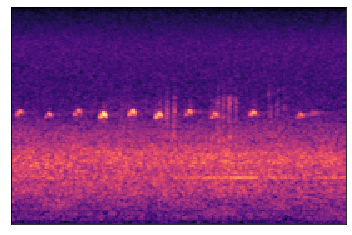

In [77]:
librosa.display.specshow(image);

These melspectrograms seem to be all single-channeled. Besides, probably due to the fact we have always taken the same number of samples (after resampling with a common `SR`), we always obtain an ndarray of shape `(128, 201)`.

In [81]:
list(range(0, 88, 5))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

## Statistics on `train_short_audio/`
I would like to know some statistics like

- How many `.ogg` files does each bird label have?
  - Linux's `tree` command might be able to answer to this question.
- How long are these `.ogg` files? Are some a lot longer than others?

In [84]:
!tree $PATH_DATASET/train_short_audio/* --filelimit 3

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/acafly [132 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/acowoo [190 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/aldfly [227 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/ameavo [44 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amecro [229 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amegfi [181 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amekes [82 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amepip [98 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_aud

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/cogdov [70 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/colcha1 [90 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/coltro1 [180 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/comgol [100 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/comgra [128 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/comloo [110 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/commer [87 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/compau [293 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_a

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/larspa [105 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/laufal1 [204 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/laugul [66 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/lazbun [120 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/leafly [154 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/leasan [62 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/lesgol [227 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/lesgre1 [91 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_a

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/roahaw [338 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/robgro [127 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rocpig [128 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rotbec [68 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/royter1 [74 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rthhum [34 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rtlhum [88 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/ruboro1 [198 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_au

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/yeofly1 [302 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/yerwar [185 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/yeteup1 [52 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/yetvir [107 entries exceeds filelimit, not opening dir]

0 directories, 0 files


Well, if we are to use `tree`, we'd be better off writing a whole shell script. Let's try it Python way.

In [92]:
PATH_DATASET.stat()

os.stat_result(st_mode=16893, st_ino=973943, st_dev=40, st_nlink=1, st_uid=1000, st_gid=1000, st_size=248, st_atime=1620472522, st_mtime=1620472522, st_ctime=1620472522)

In [91]:
PATH_DATASET.stat().st_size

248

In [93]:
len(list(PATH_DATASET.iterdir()))

7

`st_size` is the size of the file, i.e. how many bytes.

In [94]:
!ls -ld $PATH_DATASET

drwxrwxr-x. 1 phunc20 phunc20 248 May  8 18:15 /home/phunc20/datasets/kaggle/birdclef-2021


In [ ]:
D_label_nShort = dict()

In [97]:
for p in (PATH_DATASET / "train_short_audio").iterdir():
    n_oggs = len(set(p.iterdir()))
    print(f"{p.name:10s}{n_oggs: 5d}")
    D_label_index[p.name] = n_oggs

acafly      132
acowoo      190
aldfly      227
ameavo       44
amecro      229
amegfi      181
amekes       82
amepip       98
amered      283
amerob      481
amewig       38
amtspa       80
andsol1     199
annhum      123
astfly      210
azaspi1     258
babwar       53
baleag       58
balori      155
banana      309
banswa      141
banwre1     103
barant1     198
barswa      500
batpig1      85
bawswa1      87
bawwar      153
baywre1     165
bbwduc      137
bcnher      334
belkin1      77
belvir      201
bewwre      466
bkbmag1      71
bkbplo      182
bkbwar      111
bkcchi      272
bkhgro      219
bkmtou1     153
bknsti      137
blbgra1     196
blbthr1     100
blcjay1      62
blctan1      35
blhpar1     159
blkpho      134
blsspa1     111
blugrb1     154
blujay      328
bncfly      406
bnhcow      177
bobfly1     236
bongul       53
botgra       84
brbmot1      81
brbsol1     150
brcvir1      99
brebla       52
brncre      209
brnjay       66
brnthr      149
brratt1     265
brwhaw  

In [98]:
def duration(path_ogg):
    audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")
    return len(audio) / SR

The following cell can display the number of seconds each `.ogg` file lasts, but it's **time-consuming**; we'd better combine it with other loops for reading all the short audio files.
> But the result show that the duration is not quite homogeneous: it could range from as low as 6 seconds to sth like 200 seconds.

In [100]:
for p_label in (PATH_DATASET / "train_short_audio").iterdir():
    print(f"{p_label.name}")
    for p_ogg in p_label.iterdir():
        print(f"\t{p_ogg.name:20s} {duration(p_ogg): 10.2f}")

acafly
	XC109605.ogg              63.67
	XC11209.ogg               16.65
	XC127032.ogg              47.14
	XC129974.ogg              14.07
	XC129981.ogg              40.66
	XC130056.ogg              42.12
	XC130133.ogg              65.06
	XC130140.ogg              31.52
	XC130750.ogg              57.54
	XC131193.ogg              43.64
	XC133047.ogg              23.68
	XC135020.ogg              25.07
	XC135121.ogg              10.10
	XC136287.ogg             125.14
	XC136290.ogg              35.85
	XC136301.ogg              79.06
	XC137858.ogg             647.28
	XC137859.ogg             148.76
	XC138090.ogg              24.88
	XC138091.ogg              73.73
	XC138092.ogg             104.19
	XC157337.ogg              31.94
	XC163936.ogg              11.37
	XC166392.ogg              22.74
	XC178213.ogg              43.95
	XC178214.ogg              48.03
	XC182091.ogg              13.24
	XC197247.ogg              13.15
	XC203555.ogg              71.20
	XC215798.ogg              83.63
	XC

	XC448730.ogg              30.54
	XC448731.ogg              27.25
	XC448737.ogg              36.23
	XC448826.ogg               9.01
	XC450847.ogg             131.22
	XC450848.ogg              34.52
	XC450849.ogg              29.73
	XC451032.ogg              43.31
	XC451181.ogg              74.97
	XC451182.ogg              12.90
	XC451183.ogg              17.58
	XC451184.ogg              10.24
	XC451185.ogg              49.16
	XC451186.ogg              10.86
	XC451200.ogg              11.34
	XC451270.ogg             127.73
	XC451272.ogg              37.00
	XC451273.ogg              75.80
	XC451274.ogg              82.01
	XC451275.ogg             281.07
	XC451276.ogg               8.90
	XC451277.ogg              11.43
	XC451278.ogg              45.73
	XC451363.ogg              69.33
	XC452359.ogg              61.36
	XC452360.ogg              29.32
	XC453076.ogg              56.24
	XC466411.ogg             210.01
	XC466412.ogg             210.01
	XC466413.ogg              61.64
	XC466414.

	XC381871.ogg              21.37
	XC381873.ogg              81.66
	XC387530.ogg              21.70
	XC406251.ogg              45.85
	XC414551.ogg              27.78
	XC415380.ogg              28.93
	XC418144.ogg              51.45
	XC420125.ogg              21.51
	XC420402.ogg              25.11
	XC420909.ogg              31.12
	XC428334.ogg              64.02
	XC428335.ogg              24.20
	XC433096.ogg              27.09
	XC433319.ogg              65.16
	XC466987.ogg             135.80
	XC476536.ogg              24.42
	XC477186.ogg              39.23
	XC477348.ogg              53.38
	XC477364.ogg              36.85
	XC479502.ogg              43.36
	XC479504.ogg              98.30
	XC483142.ogg              28.55
	XC509611.ogg              71.37
	XC524513.ogg              16.94
	XC524514.ogg              16.26
	XC524515.ogg              19.28
	XC524851.ogg              26.50
	XC524886.ogg               9.44
	XC535041.ogg             111.03
	XC541879.ogg              18.38
	XC541883.

	XC456644.ogg             112.55
	XC459466.ogg             158.63
	XC460987.ogg              39.62
	XC462765.ogg              10.36
	XC462766.ogg              14.02
	XC462767.ogg              31.18
	XC464018.ogg              14.93
	XC475163.ogg              10.91
	XC475164.ogg              41.08
	XC475165.ogg              35.67
	XC475166.ogg              26.87
	XC478839.ogg             150.83
	XC479493.ogg              22.37
	XC480052.ogg              78.78
	XC481136.ogg              26.29
	XC481933.ogg              39.69
	XC488886.ogg              24.46
	XC496354.ogg              31.45
	XC496355.ogg             427.26
	XC496356.ogg              69.40
	XC496358.ogg             215.63
	XC506622.ogg              32.37
	XC513351.ogg             108.49
	XC51410.ogg              162.52
	XC516376.ogg              14.51
	XC524203.ogg              18.82
	XC524204.ogg              59.36
	XC524205.ogg              25.69
	XC524247.ogg              57.93
	XC524248.ogg              15.35
	XC524249.

	XC138718.ogg              22.02
	XC147272.ogg               6.21
	XC147273.ogg              16.38
	XC160904.ogg              27.49
	XC16111.ogg                7.07
	XC213165.ogg              11.51
	XC214256.ogg              43.22
	XC214257.ogg              11.17
	XC214259.ogg              11.30
	XC216657.ogg              17.36
	XC238264.ogg              17.31
	XC250844.ogg              12.97
	XC253328.ogg              11.96
	XC253935.ogg              18.20
	XC253951.ogg              20.05
	XC254588.ogg              77.79
	XC254589.ogg              73.41
	XC257401.ogg              15.40
	XC267262.ogg              15.50
	XC278000.ogg               7.09
	XC289032.ogg              49.93
	XC289663.ogg              36.19
	XC297550.ogg              17.54
	XC298663.ogg               7.56
	XC304798.ogg              48.68
	XC308302.ogg               9.81
	XC341005.ogg              26.00
	XC348428.ogg              24.73
	XC362105.ogg              24.90
	XC362208.ogg             126.40
	XC375505.

	XC190045.ogg              81.23
	XC190046.ogg              25.93
	XC190221.ogg             175.01
	XC192759.ogg              12.32
	XC193127.ogg             160.72
	XC193128.ogg             109.49
	XC193130.ogg             233.08
	XC193131.ogg              78.77
	XC193133.ogg              17.41
	XC193134.ogg              42.41
	XC193769.ogg             194.31
	XC193944.ogg             138.93
	XC194214.ogg             116.55
	XC194215.ogg              35.12
	XC195559.ogg              92.77
	XC195834.ogg             214.56
	XC195835.ogg             100.01
	XC195892.ogg              76.58
	XC196043.ogg              73.08
	XC205267.ogg              52.36
	XC205997.ogg             156.28
	XC213663.ogg              10.20
	XC216411.ogg              37.89
	XC233159.ogg              23.86
	XC237528.ogg              46.17
	XC240408.ogg              29.36
	XC241121.ogg             157.38
	XC243584.ogg              27.06
	XC243788.ogg              44.66
	XC243789.ogg              11.93
	XC243793.

	XC157683.ogg              52.34
	XC157883.ogg             173.57
	XC158033.ogg              95.36
	XC158035.ogg             516.74
	XC158036.ogg             168.87
	XC161561.ogg               9.97
	XC163126.ogg             531.03
	XC163129.ogg              58.35
	XC163130.ogg              97.14
	XC163131.ogg              30.21
	XC163132.ogg             136.92
	XC163135.ogg              75.40
	XC163137.ogg             329.94
	XC163141.ogg              29.40
	XC163143.ogg             358.18
	XC163145.ogg             267.33
	XC163146.ogg              46.41
	XC163147.ogg              43.09
	XC163148.ogg             162.50
	XC163639.ogg              51.24
	XC163653.ogg             172.03
	XC163685.ogg              13.49
	XC163785.ogg              61.07
	XC164121.ogg             131.70
	XC164441.ogg              61.09
	XC164729.ogg              42.20
	XC165269.ogg              76.74
	XC165272.ogg             209.17
	XC165275.ogg             164.75
	XC165277.ogg              15.52
	XC165278.

	XC446458.ogg             158.79
	XC446460.ogg              28.33
	XC446462.ogg             124.86
	XC448270.ogg             132.85
	XC448271.ogg              77.28
	XC448273.ogg              62.21
	XC448274.ogg               8.53
	XC448294.ogg              26.82
	XC448295.ogg              30.24
	XC451211.ogg              36.06
	XC452607.ogg              44.53
	XC452609.ogg              26.10
	XC453935.ogg              33.28
	XC456750.ogg              81.91
	XC457206.ogg              76.32
	XC458035.ogg              17.27
	XC459052.ogg              51.48
	XC461774.ogg             182.08
	XC462166.ogg              30.71
	XC462677.ogg              42.83
	XC463100.ogg               8.63
	XC463915.ogg              37.72
	XC464670.ogg              19.55
	XC464766.ogg              41.03
	XC464997.ogg             119.05
	XC464999.ogg              97.06
	XC465001.ogg              56.60
	XC465994.ogg              33.11
	XC466048.ogg              40.88
	XC466248.ogg              74.02
	XC466249.

	XC16908.ogg               22.22
	XC177225.ogg              28.29
	XC177226.ogg             180.04
	XC177477.ogg              43.33
	XC177480.ogg              70.31
	XC200103.ogg               6.91
	XC200508.ogg              10.41
	XC200509.ogg               9.60
	XC203711.ogg              25.89
	XC203713.ogg              11.58
	XC203714.ogg              75.64
	XC203716.ogg              16.55
	XC205798.ogg             128.12
	XC209759.ogg              77.21
	XC209897.ogg             103.80
	XC209898.ogg              20.70
	XC210761.ogg              49.98
	XC210762.ogg              10.12
	XC210765.ogg              83.44
	XC210766.ogg              43.19
	XC210768.ogg              23.58
	XC236564.ogg              12.27
	XC297854.ogg              51.21
	XC301854.ogg             337.59
	XC306498.ogg              51.68
	XC342346.ogg              39.04
	XC342444.ogg              10.54
	XC342952.ogg               6.62
	XC342954.ogg              18.35
	XC345976.ogg              14.67
	XC389920.

	XC74747.ogg              128.04
	XC9024.ogg                49.91
	XC9827.ogg                29.40
	XC9828.ogg                13.62
	XC9829.ogg                17.91
	XC9830.ogg                34.63
	XC9831.ogg                31.20
annhum
	XC109651.ogg              15.56
	XC109852.ogg              73.57
	XC120842.ogg             105.01
	XC120843.ogg             114.08
	XC121435.ogg              24.83
	XC124484.ogg              25.45
	XC131442.ogg               7.60
	XC132216.ogg               8.66
	XC132217.ogg              71.09
	XC132219.ogg              59.47
	XC132220.ogg              41.18
	XC132223.ogg              28.02
	XC132226.ogg              11.22
	XC132229.ogg              76.40
	XC132236.ogg              63.60
	XC132237.ogg              54.56
	XC132239.ogg              23.89
	XC132241.ogg              38.02
	XC132243.ogg               8.53
	XC132246.ogg              41.42
	XC132248.ogg              23.50
	XC132250.ogg              17.15
	XC132251.ogg             146.61
	XC

	XC304272.ogg              88.77
	XC308580.ogg              32.56
	XC316162.ogg              11.38
	XC317196.ogg              26.27
	XC318365.ogg              53.65
	XC318523.ogg              35.70
	XC324272.ogg             192.33
	XC343190.ogg             114.08
	XC343191.ogg              22.60
	XC348116.ogg              41.60
	XC348123.ogg              46.17
	XC348126.ogg             242.30
	XC365936.ogg              38.15
	XC367118.ogg             106.28
	XC368291.ogg              24.66
	XC376284.ogg             165.90
	XC377114.ogg              44.27
	XC381306.ogg              81.49
	XC381308.ogg              73.53
	XC381312.ogg             132.66
	XC399574.ogg              26.21
	XC400272.ogg             214.64
	XC404715.ogg              19.07
	XC417737.ogg              48.55
	XC418317.ogg             150.66
	XC418344.ogg              81.85
	XC419831.ogg              46.88
	XC425505.ogg              88.45
	XC425870.ogg              71.46
	XC425871.ogg              55.24
	XC425872.

	XC357269.ogg             112.42
	XC362973.ogg              22.69
	XC366830.ogg              29.09
	XC373203.ogg              75.19
	XC373204.ogg              15.79
	XC37686.ogg               40.29
	XC37734.ogg               17.86
	XC386852.ogg              36.95
	XC387062.ogg              10.57
	XC388029.ogg              11.66
	XC388037.ogg              22.92
	XC388929.ogg              18.95
	XC389767.ogg              27.68
	XC390788.ogg              47.82
	XC391618.ogg              32.28
	XC395079.ogg              43.95
	XC39531.ogg               25.82
	XC39556.ogg               40.40
	XC39577.ogg               95.75
	XC39579.ogg               69.94
	XC398358.ogg              26.15
	XC399171.ogg              19.11
	XC399287.ogg              17.90
	XC399288.ogg               8.54
	XC399289.ogg              16.75
	XC405900.ogg              26.92
	XC406060.ogg              14.22
	XC406065.ogg              25.33
	XC414142.ogg               8.74
	XC418849.ogg              33.19
	XC423758.

	XC217799.ogg             192.40
	XC217802.ogg              22.79
	XC217803.ogg              71.29
	XC217804.ogg              36.85
	XC217806.ogg              52.12
	XC217808.ogg              90.44
	XC217809.ogg             121.05
	XC217810.ogg             141.54
	XC217811.ogg               9.47
	XC236929.ogg              31.35
	XC240404.ogg             116.00
	XC240731.ogg              40.41
	XC243433.ogg              45.68
	XC243779.ogg              10.96
	XC243991.ogg              69.30
	XC244358.ogg              99.59
	XC245647.ogg             103.07
	XC247768.ogg              39.07
	XC255284.ogg              24.31
	XC256292.ogg              27.18
	XC277973.ogg              28.51
	XC277990.ogg              32.95
	XC278196.ogg               9.63
	XC286554.ogg              31.39
	XC292598.ogg              17.91
	XC31069.ogg               37.36
	XC31260.ogg               49.93
	XC313532.ogg              44.46
	XC313533.ogg              29.70
	XC315277.ogg             110.29
	XC315312.

	XC316987.ogg              34.94
	XC316989.ogg              32.33
	XC316990.ogg             100.09
	XC316991.ogg             107.77
	XC318598.ogg              45.92
	XC319635.ogg              14.75
	XC320349.ogg              19.52
	XC32051.ogg               71.64
	XC32055.ogg               83.63
	XC32074.ogg               34.03
	XC32077.ogg               24.60
	XC326973.ogg              18.66
	XC331385.ogg              31.41
	XC331386.ogg               5.96
	XC331387.ogg               8.96
	XC335021.ogg              51.33
	XC336666.ogg              45.78
	XC33682.ogg               56.05
	XC338406.ogg              14.93
	XC340263.ogg              22.98
	XC345364.ogg              12.21
	XC346009.ogg              25.88
	XC347839.ogg              93.27
	XC351514.ogg              60.36
	XC351849.ogg             192.35
	XC352977.ogg              94.71
	XC353176.ogg              14.32
	XC354864.ogg              22.98
	XC355307.ogg              34.18
	XC357044.ogg              31.99
	XC359470.

	XC380000.ogg              12.53
	XC380014.ogg              28.79
	XC380186.ogg               6.47
	XC380321.ogg               7.55
	XC380322.ogg             219.78
	XC380736.ogg             169.36
	XC399828.ogg              14.75
	XC413318.ogg              23.96
	XC414713.ogg              10.83
	XC423591.ogg              17.89
	XC423997.ogg              20.77
	XC424886.ogg              25.67
	XC426161.ogg              12.16
	XC426170.ogg               6.75
	XC430811.ogg              35.78
	XC431107.ogg              32.09
	XC434782.ogg               9.45
	XC443764.ogg              30.23
	XC447360.ogg              21.16
	XC448123.ogg             217.93
	XC464530.ogg              10.99
	XC470204.ogg              24.44
	XC470207.ogg             162.68
	XC470210.ogg              68.17
	XC470226.ogg              98.26
	XC482364.ogg              17.67
	XC483343.ogg              11.74
	XC484331.ogg              15.78
	XC485817.ogg              66.04
	XC487832.ogg              41.84
	XC493058.

	XC332325.ogg              24.59
	XC332673.ogg              19.16
	XC332674.ogg              29.56
	XC333625.ogg              84.39
	XC335506.ogg             101.03
	XC335508.ogg              71.12
	XC335882.ogg              14.51
	XC338790.ogg              56.83
	XC342820.ogg              15.79
	XC343332.ogg              62.22
	XC34532.ogg               32.43
	XC349736.ogg              25.95
	XC351637.ogg              19.50
	XC353671.ogg             124.81
	XC353673.ogg              66.41
	XC353674.ogg              67.56
	XC354235.ogg              51.06
	XC354908.ogg              33.49
	XC355318.ogg             137.42
	XC355319.ogg             115.29
	XC357244.ogg              98.52
	XC370053.ogg              12.13
	XC371053.ogg             144.11
	XC374683.ogg              60.57
	XC376312.ogg              42.31
	XC376314.ogg              10.70
	XC376824.ogg              21.43
	XC378759.ogg              22.54
	XC379472.ogg              67.75
	XC379880.ogg              26.21
	XC380822.

	XC317544.ogg              28.67
	XC317626.ogg              70.78
	XC317816.ogg              47.29
	XC318261.ogg              68.53
	XC319555.ogg              62.57
	XC319599.ogg             108.32
	XC319722.ogg              48.15
	XC320267.ogg             131.04
	XC320720.ogg               8.24
	XC320886.ogg              13.28
	XC321212.ogg             166.94
	XC322168.ogg             101.63
	XC324144.ogg              87.71
	XC324471.ogg              59.52
	XC324838.ogg              33.09
	XC324839.ogg              22.19
	XC324851.ogg              41.91
	XC324889.ogg              57.01
	XC327328.ogg              15.27
	XC327364.ogg              13.78
	XC327392.ogg              27.78
	XC329023.ogg               9.16
	XC329025.ogg              20.44
	XC329822.ogg              54.85
	XC330211.ogg              25.25
	XC330429.ogg               7.51
	XC330691.ogg              10.79
	XC331266.ogg              66.05
	XC331493.ogg              10.23
	XC331494.ogg              11.98
	XC333650.

KeyboardInterrupt: 

## `train_soundscapes/`

In [103]:
df_train_soundscape = pd.read_csv(PATH_DATASET/"train_soundscape_labels.csv")
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [105]:
df_train_soundscape.notnull().all()

row_id      True
site        True
audio_id    True
seconds     True
birds       True
dtype: bool

There are a total of `20` `.ogg` files in `train_soundscapes/`: I would like to split these into train/val/test sets.

- `12` files for train
- `4` files for val
- `4` files for test

In [130]:
n_train = 12
n_val = 4     # Maybe I will put train and val together
n_test = 4

In [116]:
L_paths_train_soundscape = list((PATH_DATASET / "train_soundscapes").iterdir())
L_paths_train_soundscape

[PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/10534_SSW_20170429.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/11254_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/14473_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/18003_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/20152_SSW_20170805.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/21767_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26709_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26746_COR_20191004.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/2782_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/28933_SSW_20170408.ogg'),
 

In [160]:
L_testSoundScapeIDs = [int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:]]
S_testSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:])
L_testSoundScapeIDs

[57610, 7019, 7843, 7954]

In [134]:
df_train_soundscape.columns

Index(['row_id', 'site', 'audio_id', 'seconds', 'birds'], dtype='object')

In [136]:
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [172]:
PATH_DATASET._str

'/home/phunc20/datasets/kaggle/birdclef-2021'

In [138]:
df_train_soundscape.dtypes

row_id      object
site        object
audio_id     int64
seconds      int64
birds       object
dtype: object

In [148]:
df_train_soundscape.audio_id

0        7019
1        7019
2        7019
3        7019
4        7019
        ...  
2395    54955
2396    54955
2397    54955
2398    54955
2399    54955
Name: audio_id, Length: 2400, dtype: int64

In [156]:
df_train_soundscape.audio_id.unique()

array([ 7019,  7954, 11254, 18003, 21767, 26746, 31928, 44957, 50878,
       57610,  2782,  7843, 10534, 14473, 20152, 26709, 28933, 42907,
       51010, 54955])

In [152]:
df_train_soundscape.audio_id.any() in L_testSoundScapeIDs

False

In [153]:
L_testSoundScapeIDs

[57610, 7019, 7843, 7954]

In [157]:
L_testSoundScapeIDs[0] in df_train_soundscape.audio_id

False

In [161]:
df_train_soundscape["is_test"] = [ (id_ in S_testSoundScapeIDs)
                                  for id_ in df_train_soundscape.audio_id]
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds,is_test
0,7019_COR_5,COR,7019,5,nocall,True
1,7019_COR_10,COR,7019,10,nocall,True
2,7019_COR_15,COR,7019,15,nocall,True
3,7019_COR_20,COR,7019,20,nocall,True
4,7019_COR_25,COR,7019,25,nocall,True


`mkdir` for places to store melspectrogram `.npy` files

In [119]:
trainSoundScapes = Path("./trainSoundScapes")
trainSoundScapes.exists()

False

In [125]:
trainSoundScapes.mkdir(exist_ok=True)
trainSoundScapes.exists()

True

In [127]:
testSoundScapes = Path("./testSoundScapes")
testSoundScapes.exists()

False

In [128]:
testSoundScapes.mkdir(exist_ok=True)
testSoundScapes.exists()

True

In [129]:
ls

01-data_exploration.ipynb  testSoundScapes/  trainSoundScapes/  trash.py


`NamedTuple` and `itertuples()` method from dataframe

In [166]:
list((PATH_DATASET / "train_soundscapes").glob("*7019_COR*.ogg"))

[PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg')]

In [167]:
next((PATH_DATASET / "train_soundscapes").glob("*7019_COR*.ogg"))

PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg')

In [ ]:
class AudioToImage:
    def __init__(self,
                 sr=SR,
                 n_mels=128,
                 fmin=0,
                 fmax=None,
                 duration=DURATION,
                 step=None,
                 res_type="kaiser_fast",
                 resample=True):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr // 2

        self.duration = duration
        self.audio_length = self.duration*self.sr  # this is the #(samples) corresponding to DURATION=5 sec
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr,
                                                 n_mels=self.n_mels,
                                                 fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = standardize_uint8(melspec)
        return image

    def __call__(self, row, save=True, save_to=None, is_short_audio=False):
        #max_audio_duration = 10*self.duration
        #init_audio_length = max_audio_duration*row.sr
        #start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)

        if save and save_to is None:
            print("Nothing was done. If you want to save=True, please specify save_to=some_path")
            return
    
        #audio, orig_sr = soundfile.read(row.filepath, dtype="float32")

        #if self.resample and orig_sr != self.sr:
        #    audio = librosa.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        #audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
        #audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
        #images = [self.audio_to_image(audio) for audio in audios]
        #images = np.stack(images)
        if not is_short_audio:
            # Then audio from train_soundscapes/
            # an audio every 5 sec
            path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"*{row.audio_id}_{row.site}*.ogg"))
            audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
            if self.resample and orig_sr != self.sr:
                audio = librosa.resample(audio, orig_sr, self.sr, res_type=self.res_type)
            start_index = (row.seconds - self.duration) * self.sr
            audio = audio[start_index:start_index + self.audio_length]
            image = self.audio_to_image(audio)
          
        if save:
            #path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/f"{row.primary_label}/{row.filename}.npy"
            path = save_to / f"{row.row_id}.npy"
            path.parent.mkdir(exist_ok=True, parents=True)
            np.save(str(path), image)
        else:
            return  row.row_id, image


def get_audios_as_images(df, save_to=None):
    pool = joblib.Parallel(4)
    
    #converter = AudioToImage(step=int(DURATION*0.666*SR))
    #def __call__(self, row, save=True, save_to=None, is_short_audio=False):
    converter = AudioToImage()
    mapper = joblib.delayed(converter)
    #tasks = [mapper(row) for row in df.itertuples(False)]
    tasks = [mapper(row, save_to=save_to) for row in df.itertuples(False)]
    
    pool(tqdm(tasks))

### So Wrong
There are a few drawbacks in the previous two cells:
- It was wrong by saving all `.npy` files to `trainSoundScape` directory: Some should be saved to `testSoundScape` directory.
- It is not sufficient because the same `.ogg` file is opened and read several times.
  - Write a function or a class of your own and stop using kkiller's in this case.

### Save `.npy` Files
Let's make our objectives clear.

01. We want to save each `train_soundscapes/` audio file, each 5-sec clip, to an `.npy` file.
  - The file reading and melspectrogram transform might be quite blocking, so **asynchronous** or **multi-process** (e.g. `concurrent.futures.ProcessPoolExecutor` or `joblib`) programming might be useful here.
02. We want to update `df_train_soundscape` to contain more information. What information?
  - Date: Can be separated.
  - Corresponding `.npy` path: Can be separated.
  - Longitude, latitude: Can be separated.
  
Since the two objectives above can be separated, and updating an extra dataframe while saving `.npy` for each `.ogg` file can become quite complicated, let's first get objective 1 done and start objective 2 after that.

### Objective 1: `.ogg` to `.npy`

#### `joblib` way

In [183]:
list(range(10))[0:-3]

[0, 1, 2, 3, 4, 5, 6]

In [184]:
list(range(10))[:-3]

[0, 1, 2, 3, 4, 5, 6]

In [187]:
S_trainSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[:-n_test])
S_trainSoundScapeIDs#, len(S_trainSoundScapeIDs)

{2782,
 10534,
 11254,
 14473,
 18003,
 20152,
 21767,
 26709,
 26746,
 28933,
 31928,
 42907,
 44957,
 50878,
 51010,
 54955}

In [193]:
next((PATH_DATASET / "train_soundscapes").glob(f"50878*.ogg"))

PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/50878_COR_20191004.ogg')

In [ ]:
def audio_to_mels(audio,
                  sr=SR,
                  n_mels=128,
                  fmin=0,
                  fmax=None,
                  duration=DURATION,
                  res_type="kaiser_fast",
                  resample=True):
    fmax = fmax or sr // 2
    n_samples = duration * sr
    mel_spec_computer = MelSpecComputer(sr=sr,
                                        n_mels=n_mels,
                                        fmin=fmin,
                                        fmax=fmax)
    mels = standardize_uint8(mel_spec_computer(audio))

def every_5sec(id_,
                sr=SR,
                resample=True,
                res_type="kaiser_fast"
                ):
    """
    - read the audio file of ID `id_`
    - cut the read audio into pieces of 5 seconds
    - convert each piece into `.npy` file and save
    """
    path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"{id_}*.ogg"))
    whole_audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    if resample and orig_sr != sr:
        whole_audio = librosa.resample(whole_audio, orig_sr, sr, res_type=res_type)
    n_samples = len(whole_audio)
    n_samples_5sec = sr * 5
    # single-process version
    # multiple-process version
start_index = (row.seconds - self.duration) * self.sr
audio = audio[start_index:start_index + self.audio_length]
image = self.audio_to_image(audio)


def soundscapes_to_npy(S, is_test=False, save=True, n_processes=4):
    """
    arg
      S, set
        either S_trainSoundScapeIDs or S_testSoundScapeIDs
    """
    pool = joblib.Parallel(n_processes)
    mapping = joblib.delayed()
    if is_test:
        tasks = (mapping(id_ ) for id_ in S_testSoundScapeIDs)
    else:
        tasks = (mapping(id_ ) for id_ in S_trainSoundScapeIDs)
    pool(tqdm(tasks))




Construct a dictionary for

- key: recording location, e.g. `COR`, `SSW`, etc.
- value: possibly `NamedTuple(longitude, latitude)`

Fill in date info to `train_soundscape_labels.csv` from `train_soundscapes/`